# Phase noise

## Import zone

In [188]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as ct
import pandas as pd

from matplotlib.patches import Rectangle, ConnectionPatch
from matplotlib.ticker import ScalarFormatter
from matplotlib import rcParams

# --- Global style (same as your main plot) ---
rcParams['font.family'] = 'STIXGeneral'
rcParams['mathtext.fontset'] = 'stix'
rcParams['axes.unicode_minus'] = False
rcParams.update({
    "font.size": 14,
    "axes.labelsize": 15,
    "axes.titlesize": 15,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "axes.linewidth": 1.2,
    "lines.linewidth": 1.5,
    "grid.alpha": 0.6,
    "grid.linestyle": "--",
    "figure.facecolor": "white",
    "axes.facecolor": "white",
})

from functools import partial
from scipy.optimize import curve_fit
from matplotlib.patches import Rectangle, ConnectionPatch
from matplotlib.ticker import ScalarFormatter

from src.systems.linear_traps import ThreeRFTrap
from src.io.loading import load_threeRF_geometry
from src.geometry.geometry_utils import check_all_ccw

## Load trap geometry

In [189]:
geometry = load_threeRF_geometry("src/resources/ThreeRF_params.json")

# Trench width
trench_width = 5

# Set segmentation flags
flags = {
    "build_outer_RF": True,
    "build_central_RF": True,
}

flags_outer = {"build_central_RF": False}
flags_central = {"build_outer_RF": False}

# Build trap
trap = ThreeRFTrap(geometry, trench_width, flags)
system = trap.build()
system_central = trap.build(flags=flags_central)
system_outer = trap.build(flags=flags_outer)

check_all_ccw(system)
check_all_ccw(system_outer)
check_all_ccw(system_central)

All electrodes are CCW.
All electrodes are CCW.
All electrodes are CCW.


/home/kallo27/thesis/src/systems/linear_traps.py:240: UserWarning: Flag 'build_outer_RF' is False, but RF geometry is provided.
  warnings.warn("Flag 'build_outer_RF' is False, but RF geometry is provided.")
/home/kallo27/thesis/src/systems/linear_traps.py:236: UserWarning: Flag 'build_central_RF' is False, but RF geometry is provided.
  warnings.warn("Flag 'build_central_RF' is False, but RF geometry is provided.")


## Build whole system

In this part we build the whole system and then we compute the minima positions, the value of the pseudopotential as the RF ratio changes and the secular frequencies

In [190]:
csi_values = np.linspace(-1., 1.5, 1001)
x0 = (0., 0., 350.)
x1 = (0., 0., 10.)
minimum_positions_0 = []
pot_values_0 = []
E_norm_sqr = []
secular_frequencies = []

L = 1e-6 # um length scale
M = 40 * ct.atomic_mass # ion mass (calcium)
Q = 1 * ct.elementary_charge # ion charge (single-ion)
Omega = 2 * np.pi * 19e6
V0 = 100

scale = Q / (2 * Omega * np.sqrt(M))

for csi in csi_values:
    A1 = csi
    A2 = 1
    
    voltages = {
        "central_RF": {"attr": "rf", "value": A1},
        "outer_RF": {"attr": "rf", "value": A2},
    }

    voltages_central = {"central_RF": {"attr": "rf", "value": 1}}
    voltages_outer = {"outer_RF": {"attr": "rf", "value": 1}}

    system = trap.build(voltages)
    system_central = trap.build(voltages_central, flags_central)
    system_outer = trap.build(voltages_outer, flags_outer)

    try:
        if csi > 0.75:
            x0[0] += 1
        x0 = system.minimum(x0=(x0[0], x0[1], x0[2]), axis=(0,2), coord=np.identity(3), method="Powell")
        minimum_positions_0.append(x0)
        
        E1 = system_central.electrical_potential(x=x0, typ="rf", derivative=1)
        E2 = system_outer.electrical_potential(x=x0, typ="rf", derivative=1)
        
        ERF1 = A1 * E1
        ERF2 = A2 * E2
        ERF = ERF1 + ERF2
        
        E_norm_sqr.append(np.einsum("ij,ij->i", ERF, ERF))
        pot_values_0.append(scale**2 * np.einsum("ij,ij->i", ERF, ERF) * (V0/L)**2)
        
        # Compute secular frequencies
        curve_z = system.modes(x0)
        omega_sec = np.sqrt(abs(curve_z[0]) / M * (scale * V0 / L**2)**2)
        secular_frequencies.append(omega_sec)
    except:
        print(csi, "minimum not found")

/home/kallo27/anaconda3/lib/python3.11/site-packages/electrode-1.5+dev-py3.11-linux-x86_64.egg/electrode/system.py:439: RuntimeWarning: Method Powell does not use gradient information (jac).
  res = optimize.minimize(fun=f, x0=x0, jac=g, hess=h,
/home/kallo27/anaconda3/lib/python3.11/site-packages/electrode-1.5+dev-py3.11-linux-x86_64.egg/electrode/system.py:439: RuntimeWarning: Method Powell does not use Hessian information (hess).
  res = optimize.minimize(fun=f, x0=x0, jac=g, hess=h,


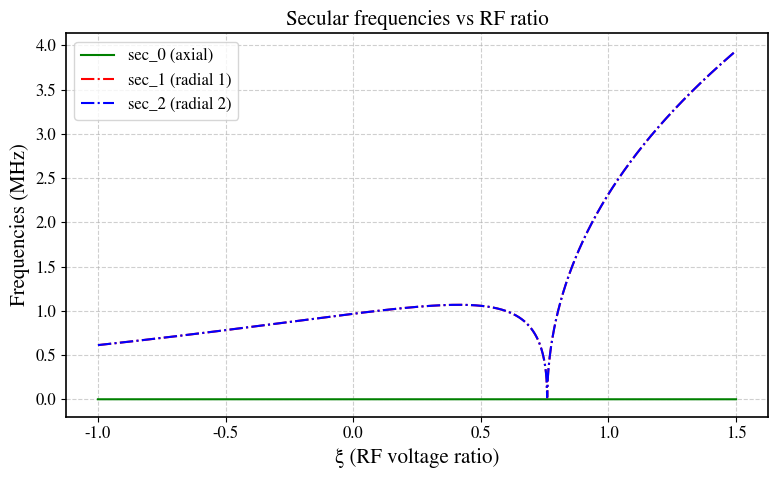

In [191]:
# Convert to arrays for slicing
sec_0 = np.array(secular_frequencies)[:,0]/(2*np.pi)/1e6
sec_1 = np.array(secular_frequencies)[:,1]/(2*np.pi)/1e6
sec_2 = np.array(secular_frequencies)[:,2]/(2*np.pi)/1e6

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot z and x components for both datasets
ax.plot(csi_values, sec_0, label='sec_0 (axial)', color='green', linestyle='-')
ax.plot(csi_values, sec_1, label='sec_1 (radial 1)', color='red', linestyle='-.')
ax.plot(csi_values, sec_2, label='sec_2 (radial 2)', color='blue', linestyle='-.')

# Add labels and grid
ax.set_xlabel('ξ (RF voltage ratio)')
ax.set_ylabel('Frequencies (MHz)')
ax.set_title('Secular frequencies vs RF ratio')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

## Load experimental data

In [217]:
df = pd.read_excel("src/data/heating rate data.xlsx")

csi_exp = df.iloc[:, 0].values
h_exp = df.iloc[:, 1].values
error_h_exp = df.iloc[:, 2].values
freq_exp = df.iloc[:, 3].values

# Find corresponding indices
indices = []
for csi in csi_exp:
    idx = np.where(np.isclose(csi_values, np.round(csi, 2)))[0]
    if len(idx) == 0:
        raise ValueError(f"csi value {csi} not found in csi_values!")
    indices.append(idx[0])
indices = np.array(indices)

In [218]:
def plot_hr_with_logscale(
    csi_exp, h_exp, error_h_exp, freq_exp,
    sec_0, csi_values,
    figsize=(10, 4)
):
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharex=True)

    # Identify minimum
    min_index = np.argmin(sec_0)
    csi_at_min = csi_values[min_index]

    # ---------- Plotting function (reusable for both panels) ----------
    def make_panel(ax, log_y=False):
        # Error bars in front (small errors)
        ax.errorbar(
            csi_exp[:7],
            h_exp[:7],
            yerr=error_h_exp[:7],
            fmt='none',
            ecolor='black',
            capsize=4,
            zorder=3
        )

        # Error bars behind (large errors)
        ax.errorbar(
            csi_exp[7:],
            h_exp[7:],
            yerr=error_h_exp[7:],
            fmt='none',
            ecolor='black',
            capsize=4,
            zorder=1
        )

        # Colored scatter
        sc = ax.scatter(
            csi_exp,
            h_exp,
            c=freq_exp,
            cmap='Spectral_r',
            s=60,
            edgecolor='black',
            zorder=2
        )

        ax.set_xlabel(r"RF ratio $(\xi_{\mathrm{RF}})$")
        ax.set_ylabel("Heating rate (phonon/s)")
        ax.set_xlim(-1.1, 1.6)
        ax.grid(True, which='both', linestyle='--', alpha=0.6, zorder=0)

        # Highlight span
        ax.axvspan(csi_at_min, ax.get_xlim()[1], color="#FBE201", alpha=0.5, zorder=0)

        # Tick formatting
        ax.ticklabel_format(style='sci', axis='both', scilimits=(0, 0))

        # Log scale if needed
        if log_y:
            ax.set_yscale('log')

        return sc

    # ---------- Left subplot (linear) ----------
    sc0 = make_panel(axes[0], log_y=False)

    # ---------- Right subplot (log scale) ----------
    sc1 = make_panel(axes[1], log_y=True)

    # One shared colorbar
    cbar_ax = fig.add_axes([0.91, 0.11, 0.01, 0.77])
    cbar = fig.colorbar(sc1, cax=cbar_ax)
    cbar.set_label('Radial secular frequency (MHz)', rotation=270, labelpad=20)

    plt.subplots_adjust(wspace=0.25) 
    return fig

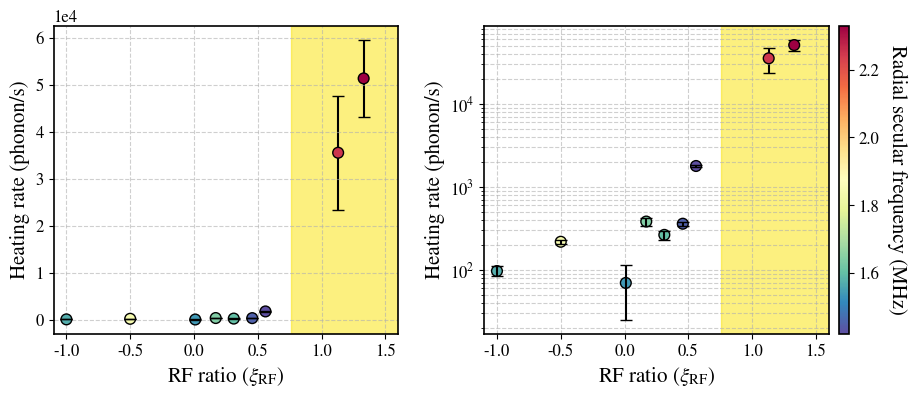

In [219]:
fig = plot_hr_with_logscale(
    csi_exp, h_exp, error_h_exp, freq_exp,
    sec_0, csi_values
)
fig.savefig("/home/kallo27/thesis/thesis_images/hr_exp_data.pdf", bbox_inches="tight")

In [220]:
# Rescale y_data
for i in range(len(h_exp)):
    scale_factor = freq_exp[i] / sec_1[indices][i]
    h_exp[i] *= scale_factor
    error_h_exp[i] *= scale_factor  # Scale error accordingly

## Compute gradient components

In [221]:
gradient_with_noise = []

flags_outer = {"build_central_RF": False}
flags_central = {"build_outer_RF": False}

for i in range(len(csi_values)):
    voltages_outer = {"outer_RF": {"attr": "rf", "value": 1}}
    voltages_central = {"central_RF": {"attr": "rf", "value": csi_values[i]}}
    
    system_outer = trap.build(voltages_outer, flags_outer)
    system_central = trap.build(voltages_central, flags_central)
    
    try:
        grad_E_O = -system_outer.electrical_potential(x=minimum_positions_0[i], typ="rf", derivative=2, expand=True)[0] * (V0 / L**2)
        E_O = -system_outer.electrical_potential(x=minimum_positions_0[i], typ="rf", derivative=1)[0] * (V0 / L)
        
        grad_E_I = -system_central.electrical_potential(x=minimum_positions_0[i], typ="rf", derivative=2, expand=True)[0] * (V0 / L**2)
        E_I = -system_central.electrical_potential(x=minimum_positions_0[i], typ="rf", derivative=1)[0] * (V0 / L)
                
        gradient_with_noise.append(np.einsum("i, ij -> j", E_O, grad_E_I) + np.einsum("i, ij -> j", E_I, grad_E_O))
        
    except:
        print(csi_values[i], "grad(phi) not found")

/home/kallo27/thesis/src/systems/linear_traps.py:236: UserWarning: Flag 'build_central_RF' is False, but RF geometry is provided.
  warnings.warn("Flag 'build_central_RF' is False, but RF geometry is provided.")
/home/kallo27/thesis/src/systems/linear_traps.py:240: UserWarning: Flag 'build_outer_RF' is False, but RF geometry is provided.
  warnings.warn("Flag 'build_outer_RF' is False, but RF geometry is provided.")


## Compute heating rates

In [223]:
def heating_rates_phase(grad_E, S_phi, axis=0):
    factor = 1 / (256 * M * ct.hbar * (sec_1*1e6*2*np.pi))
    grad_pot_sqr = (np.array(grad_E)[:, axis] * scale**2)**2
    h_O = factor * grad_pot_sqr * S_phi
    return h_O

In [224]:
def plot_heating_rates(csi_values, heating_rate_x, heating_rate_z, csi_exp, h_exp, error_h_exp, title=None, log=False):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

    # Plot X axis
    axs[0].plot(csi_values, heating_rate_x, label="Heating rate", color="darkblue")
    axs[0].errorbar(csi_exp, h_exp, yerr=error_h_exp, fmt='o',
                    markersize=6, color='tab:red', ecolor='tab:grey',
                    capsize=4, label='Experimental data')

    axs[0].set_ylabel("Heating rate", fontsize=18)
    axs[0].set_xlabel(r"RF ratio $(\xi_{{RF}})$", fontsize=18)
    axs[0].set_title("X axis", fontsize=18)
    axs[0].grid(True)
    axs[0].tick_params(axis='both', which='major', labelsize=14)

    # Plot Z axis
    axs[1].plot(csi_values, heating_rate_z, label="Heating rate", color="darkblue")
    axs[1].errorbar(csi_exp, h_exp, yerr=error_h_exp, fmt='o',
                    markersize=6, color='tab:red', ecolor='tab:grey',
                    capsize=4, label='Experimental data')

    axs[1].set_ylabel("Heating rate", fontsize=18)
    axs[1].set_xlabel(r"RF ratio $(\xi_{{RF}})$", fontsize=18)
    axs[1].set_title("Y axis", fontsize=18)
    axs[1].grid(True)
    axs[1].tick_params(axis='both', which='major', labelsize=14)

    # Use scientific notation on both plots
    for ax in axs:
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((6, 6))  # Force 1e6 scale
        ax.yaxis.set_major_formatter(formatter)
        ax.ticklabel_format(style='scientific', axis='y', scilimits=(4, 4))
        ax.yaxis.offsetText.set_fontsize(14)

    if title:
        fig.suptitle(title, fontsize=20)
        
    if log:
        axs[0].set_yscale("log")
        axs[1].set_yscale("log")
    else:
        axs[0].set_ylim(-1e3, 4.1e4)
        axs[1].set_ylim(-1e3, 4.1e4)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3)
    plt.show()


In [225]:
heating_rate_x = heating_rates_phase(gradient_with_noise, S_phi=1.5e-13, axis=0)
heating_rate_y = heating_rates_phase(gradient_with_noise, S_phi=1.5e-13, axis=1)
heating_rate_z = heating_rates_phase(gradient_with_noise, S_phi=1.7e-15, axis=2)

In [227]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter


def plot_heating_rates(csi_values, heating_rate_x, heating_rate_z,
                       csi_exp, h_exp, error_h_exp, name, title=None):

    fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey='row')

    def make_panel(ax, csi_values, heating_model, fmt):
        ax.plot(csi_values, heating_model, color="#003366", label=f"{name} noise model")
        ax.errorbar(
            csi_exp, h_exp, yerr=error_h_exp, fmt=fmt,
            markersize=6, color='#8B0000',
            ecolor='black', markeredgecolor='black', markeredgewidth=0.5,
            capsize=4, label="Measured HR"
        )
        ax.grid(True, which='both')
        ax.tick_params(axis='both', which='major')

        # Scientific formatting
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((5, 5))
        ax.yaxis.set_major_formatter(formatter)
        ax.ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        ax.yaxis.offsetText.set_fontsize(14)
        

        # Add legend
        ax.legend(fontsize=12)

    # ---------------- Column 0 = X-mode ----------------
    make_panel(axs[0, 0], csi_values, heating_rate_x, 'o')  # top: linear
    axs[0, 0].set_yscale("linear")
    axs[0, 0].set_ylabel("Heating rate (phonon/s)")


    make_panel(axs[1, 0], csi_values, heating_rate_x, 'o')  # bottom: log
    axs[1, 0].set_yscale("log")
    axs[1, 0].set_ylabel("Heating rate (phonon/s)")
    axs[1, 0].set_xlabel(r"RF ratio $(\xi_{\mathrm{RF}})$")

    # ---------------- Column 1 = Z-mode ----------------
    make_panel(axs[0, 1], csi_values, heating_rate_z, 's')  # top: linear
    axs[0, 1].set_yscale("linear")


    make_panel(axs[1, 1], csi_values, heating_rate_z, 's')  # bottom: log
    axs[1, 1].set_yscale("log")
    axs[1, 1].set_xlabel(r"RF ratio $(\xi_{\mathrm{RF}})$")

    # ---------------- Set row-specific y-limits ----------------
    top_ylim = (-0.15e4, 4.15e4)     # linear top row
    bottom_ylim = (1e1, 1e5)         # log bottom row

    axs[0, 0].set_ylim(top_ylim)
    axs[0, 1].set_ylim(top_ylim)

    axs[1, 0].set_ylim(bottom_ylim)
    axs[1, 1].set_ylim(bottom_ylim)
    
    axs[0, 0].set_title(r"X mode ($\dot\bar{n}_x$)")
    axs[0, 1].set_title(r"Y mode ($\dot\bar{n}_y$)")
    for ax in [axs[0, 0], axs[0, 1]]:
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style='sci', axis='y', scilimits=(4, 4))  # force 1e4
        ax.yaxis.offsetText.set_fontsize(14)

    if title:
        fig.suptitle(title, fontsize=20)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.07, wspace=0.1)

    return fig

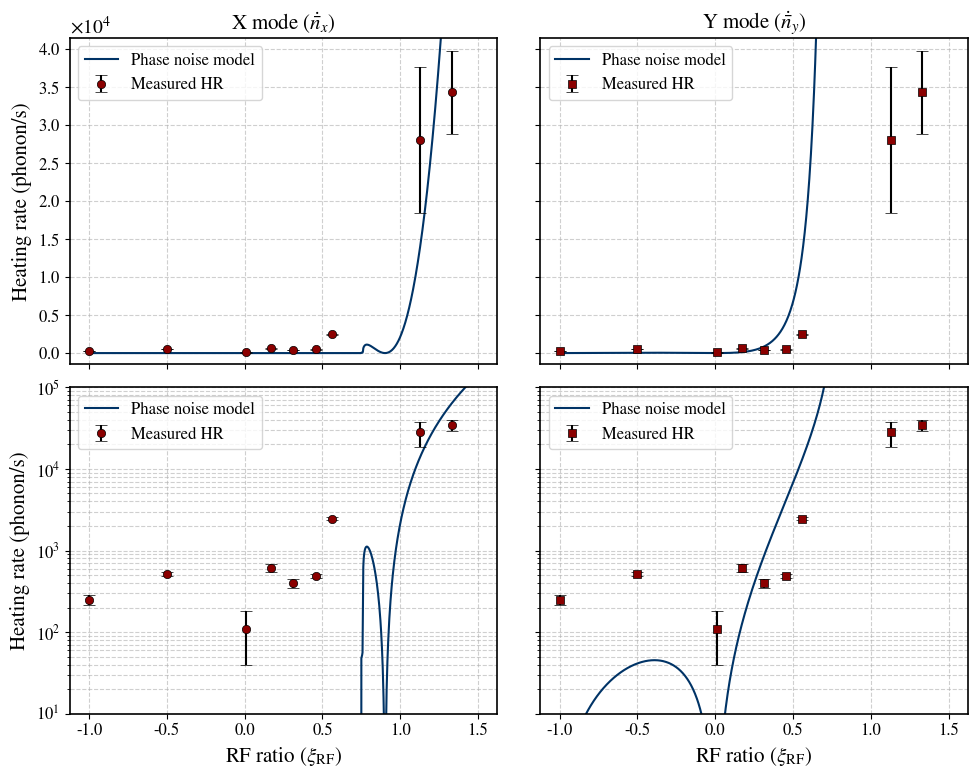

In [228]:
fig = plot_heating_rates(csi_values, heating_rate_x, heating_rate_z, csi_exp, h_exp, error_h_exp, 'Phase')

In [229]:
heating_rate_x = heating_rates_phase(gradient_with_noise, S_phi=1e-14, axis=0)
heating_rate_y = heating_rates_phase(gradient_with_noise, S_phi=1e-16, axis=2)
heating_rate_z = heating_rates_phase(gradient_with_noise, S_phi=1e-14, axis=1)

In [230]:
def plot_phase_noise_zoom(csi_values, heating_rate_x, heating_rate_y, heating_rate_z, sec_1):

    # Matched color palette
    colors = {
        "axial": "#003366",
        "radial_y": "#006400",
        "radial_x": "#8B0000",
        "highlight": "#FBE201"
    }

    fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=False)

    # --------------------------- MAIN PLOT ---------------------------
    axs[0].plot(csi_values, heating_rate_x, label=r"$\dot{\bar{n}}_x$", color=colors["radial_x"])
    axs[0].plot(csi_values, heating_rate_y, label=r"$\dot{\bar{n}}_y$", color=colors["radial_y"])
    axs[0].plot(csi_values, heating_rate_z, label=r"$\dot{\bar{n}}_z$", color=colors["axial"])

    axs[0].set_ylabel("Heating rate (phonon/s)")
    axs[0].set_xlabel(r"RF amplitude ratio $(\xi_{\mathrm{RF}})$")
    axs[0].legend(loc="upper left")
    axs[0].grid(True)
    axs[0].set_axisbelow(True)
    axs[0].tick_params(axis='both', which='major')

    # ---------------------- ZOOM REGION BOX -------------------------
    x1, x2 = 0.1, 1.6
    y1, y2 = -2e3, 7e4

    zoom_rect = Rectangle(
        (x1, y1), x2 - x1, y2 - y1,
        linewidth=1.2,
        edgecolor="black",
        linestyle="--",
        facecolor="white",
        alpha=0.8
    )
    axs[0].add_patch(zoom_rect)

    # --------------------------- ZOOMED PLOT ---------------------------
    axs[1].plot(csi_values, heating_rate_x, label=r"$\dot{\bar{n}}_x$", color=colors["radial_x"])
    axs[1].plot(csi_values, heating_rate_y, label=r"$\dot{\bar{n}}_y$", color=colors["radial_y"])
    axs[1].plot(csi_values, heating_rate_z, label=r"$\dot{\bar{n}}_z$", color=colors["axial"])
    
    
    axs[1].set_xlim(x1, x2)
    axs[1].set_ylim(y1, y2)
    axs[1].legend(loc="upper left")
    axs[1].grid(True)
    axs[1].set_xlabel(r"RF amplitude ratio $(\xi_{\mathrm{RF}})$")
    axs[1].tick_params(axis='both', which='major')
    
    # --- Right axis: secular frequency ---
    ax2 = axs[1].twinx()
    ax2.plot(csi_values, sec_1, label="Radial \nsecular frequency", linestyle='-.', color="tab:grey", linewidth=0.9, zorder=0)
    ax2.set_ylabel("Frequency (MHz)", color="tab:grey", rotation=270, labelpad=20)
    ax2.tick_params(axis='y', labelcolor="tab:grey")

    # --- Align zeros: adjust the right axis to match the left one ---
    left_min, left_max = axs[1].get_ylim()
    right_min, right_max = 0, 6  # desired nominal range before alignment

    # Compute scale so that zero lines up with the left axis zero
    right_span = right_max - right_min
    left_span = left_max - left_min
    adjusted_right_max = right_span * (left_max / left_span)
    ax2.set_ylim(left_min/left_span*right_span, adjusted_right_max)    

    # --------------------------- CONNECTION PATCHES ---------------------------
    for (yA, yB) in [(y1, y1), (y2, y2)]:
        con = ConnectionPatch(
            xyA=(x1, yA), coordsA=axs[0].transData,
            xyB=(x1, yB), coordsB=axs[1].transData,
            arrowstyle="->", color="black", linewidth=1.2, alpha=0.8
        )
        fig.add_artist(con)

    # --------------------------- SCIENTIFIC FORMAT ---------------------------
    for ax in axs:
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((6, 6))
        ax.yaxis.set_major_formatter(formatter)
    
    axs[0].ticklabel_format(style='scientific', axis='y', scilimits=(6, 6))
    axs[1].ticklabel_format(style='scientific', axis='y', scilimits=(4, 4))

    axs[0].axvspan(0.76, 1.5, color="#FBE201", alpha=0.5, zorder=0)
    axs[1].axvspan(0.76, 1.5, color="#FBE201", alpha=0.5, zorder=0)
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.15)
    return fig

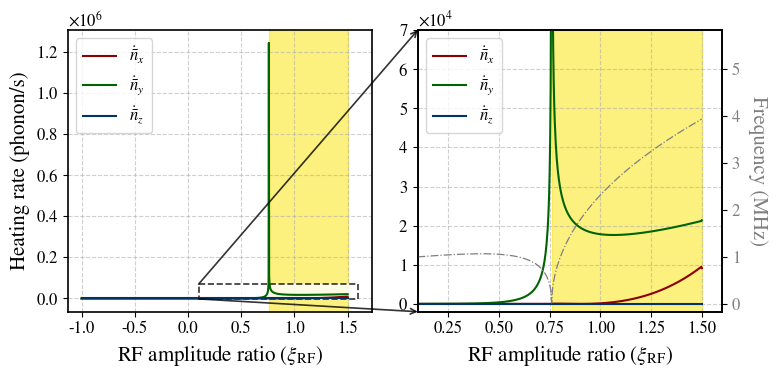

In [231]:
fig = plot_phase_noise_zoom(csi_values, heating_rate_x, heating_rate_y, heating_rate_z, sec_1)
fig.savefig("/home/kallo27/thesis/thesis_images/hr_phase_noise.pdf", bbox_inches="tight")

## Fit heating rates

In [232]:
# Wrapper for curve_fit — x is ignored
def model(dummy_x, S_phi, axis=0):
    hr = heating_rates_phase(gradient_with_noise, S_phi=S_phi, axis=axis)
    return hr[indices]

In [254]:
# Dummy x data (ignored by the model, but required by curve_fit)
x_dummy = np.zeros(len(h_exp))

# X axis
popt_x, pcov_x = curve_fit(
    partial(model, axis=0),
    x_dummy,
    h_exp,
    p0=[1e-13],
    sigma=error_h_exp,
    absolute_sigma=True,
    bounds=(0, np.inf)  # Enforce S_V_O ≥ 0
)

# Z axis
popt_z, pcov_z = curve_fit(
    partial(model, axis=2),
    x_dummy,
    h_exp,
    p0=[1e-16],
    sigma=error_h_exp,
    absolute_sigma=True,
    bounds=(0, 2e-15)  # Enforce S_V_O ≥ 0
)


best_S_phi_x = popt_x[0]
best_S_phi_z = popt_z[0]

print("BEST PARAMETERS FROM THE FIT")
print("------------------------------------------------")
print("------------------------------------------------")
print("X axis")

print("Best S_phi:", best_S_phi_x)
print(f"Fit error: {np.sqrt(pcov_x[0])}")

print("------------------------------------------------")
print("------------------------------------------------")
print("Z axis")


print("Best S_phi:", best_S_phi_z)
print(f"Fit error: {np.sqrt(pcov_z[0])}")

print("------------------------------------------------")
print("------------------------------------------------")

BEST PARAMETERS FROM THE FIT
------------------------------------------------
------------------------------------------------
X axis
Best S_phi: 8.492695702020761e-14
Fit error: [1.29405575e-14]
------------------------------------------------
------------------------------------------------
Z axis
Best S_phi: 2.701795872302971e-16
Fit error: [7.76532991e-18]
------------------------------------------------
------------------------------------------------


In [259]:
def plot_heating_rates(csi_values, heating_rate_x, heating_rate_z,
                       csi_exp, h_exp, error_h_exp, name, title=None):

    fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey='row')

    def make_panel(ax, csi_values, heating_model, fmt):
        ax.plot(csi_values, heating_model, color="#003366", label=f"{name} noise model")
        ax.errorbar(
            csi_exp, h_exp, yerr=error_h_exp, fmt=fmt,
            markersize=6, color='#8B0000',
            ecolor='black', markeredgecolor='black', markeredgewidth=0.5,
            capsize=4, label="Measured HR"
        )
        ax.grid(True, which='both')
        ax.tick_params(axis='both', which='major')

        # Scientific formatting
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((5, 5))
        ax.yaxis.set_major_formatter(formatter)
        ax.ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        ax.yaxis.offsetText.set_fontsize(14)
        

        # Add legend
        ax.legend(fontsize=12)

    # ---------------- Column 0 = X-mode ----------------
    make_panel(axs[0, 0], csi_values, heating_rate_x, 'o')  # top: linear
    axs[0, 0].set_yscale("linear")
    axs[0, 0].set_ylabel("Heating rate (phonon/s)")


    make_panel(axs[1, 0], csi_values, heating_rate_x, 'o')  # bottom: log
    axs[1, 0].set_yscale("log")
    axs[1, 0].set_ylabel("Heating rate (phonon/s)")
    axs[1, 0].set_xlabel(r"RF ratio $(\xi_{\mathrm{RF}})$")

    # ---------------- Column 1 = Z-mode ----------------
    make_panel(axs[0, 1], csi_values, heating_rate_z, 's')  # top: linear
    axs[0, 1].set_yscale("linear")


    make_panel(axs[1, 1], csi_values, heating_rate_z, 's')  # bottom: log
    axs[1, 1].set_yscale("log")
    axs[1, 1].set_xlabel(r"RF ratio $(\xi_{\mathrm{RF}})$")

    # ---------------- Set row-specific y-limits ----------------
    top_ylim = (-0.15e4, 4.15e4)     # linear top row
    bottom_ylim = (1, 1e5)         # log bottom row

    axs[0, 0].set_ylim(top_ylim)
    axs[0, 1].set_ylim(top_ylim)

    axs[1, 0].set_ylim(bottom_ylim)
    axs[1, 1].set_ylim(bottom_ylim)
    
    axs[0, 0].set_title(r"X mode ($\dot\bar{n}_x$)")
    axs[0, 1].set_title(r"Y mode ($\dot\bar{n}_y$)")
    for ax in [axs[0, 0], axs[0, 1]]:
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style='sci', axis='y', scilimits=(4, 4))  # force 1e4
        ax.yaxis.offsetText.set_fontsize(14)

    if title:
        fig.suptitle(title, fontsize=20)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.07, wspace=0.1)

    return fig

In [269]:
heating_rate_x = heating_rates_phase(gradient_with_noise, S_phi=best_S_phi_x, axis=0)
heating_rate_z = heating_rates_phase(gradient_with_noise, S_phi=1.7e-16, axis=2)

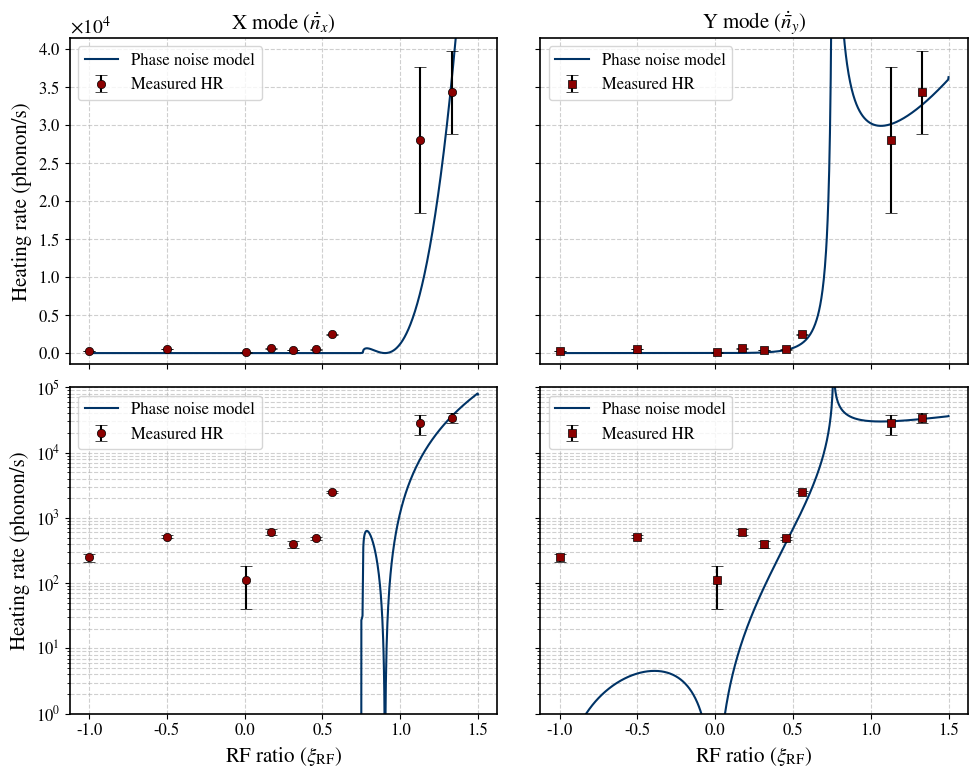

In [271]:
fig = plot_heating_rates(csi_values, heating_rate_x, heating_rate_z, csi_exp, h_exp, error_h_exp, 'Phase')
fig.savefig('/home/kallo27/thesis/thesis_images/hr_phase_xy.pdf', bbox_inches="tight")